# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.657743852333742 -2.8972871151807023
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [57]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    targetQs2 = tf.placeholder(tf.float32, [None], name='targetQs2')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rate = tf.placeholder(tf.float32, [], name='rate')
    return states, actions, targetQs, targetQs2, rewards, rate

In [58]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [59]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [60]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator2(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator2', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [91]:
def model_loss(action_size, hidden_size, states, actions, targetQs, targetQs2, rewards, rate):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    Qs_label = tf.reshape(rewards[:-1] + (0.99*targetQs[1:]), shape=[-1, 1])
    Qs_label = tf.concat(axis=0, values=[Qs_label, tf.reshape(rewards[-1], shape=[1, 1])])
    d_loss = tf.reduce_mean(tf.square(Qs_logits - Qs_label))
    #     d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
    #                                                                     labels=rewards))
    #     g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
    #                                                                      labels=tf.nn.sigmoid(Qs_label)))    
    
    Qs2_logits = discriminator2(actions=actions_logits, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    Qs2_logits += discriminator2(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True) # Q=sum(rewards)
    Qs2_logits += discriminator2(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs2_logits /= 3
    d2_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                     labels=rate*tf.ones_like(Qs2_logits)))
    #     g_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
    #                                                                      labels=tf.ones_like(Qs2_logits)))
    
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward 
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_label * tf.nn.sigmoid(targetQs2))
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_label * targetQs2)
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_label)
    g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs2)

    return actions_logits, Qs_logits, Qs2_logits, g_loss, d_loss, d2_loss

In [92]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, d2_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    d2_vars = [var for var in t_vars if var.name.startswith('discriminator2')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        d2_opt = tf.train.AdamOptimizer(learning_rate).minimize(d2_loss, var_list=d2_vars)

    return g_opt, d_opt, d2_opt

In [93]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.targetQs2, self.rewards, self.rate = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.Qs2_logits, self.g_loss, self.d_loss, self.d2_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, targetQs2=self.targetQs2, 
            rewards=self.rewards, rate=self.rate) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.d2_opt = model_opt(g_loss=self.g_loss, 
                                                        d_loss=self.d_loss, 
                                                        d2_loss=self.d2_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [94]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(9, 4) actions:(9,)
action size:1


In [95]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [96]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [97]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [98]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(1111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        #for step in (111111111111):
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            Q_logits, Q2_logits = sess.run([model.Qs_logits, model.Qs2_logits], 
                                           feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                      model.actions: np.array([action])})
            #targetQ = Q_logits * (1-float(done))
            batch.append([state, action, Q_logits, Q2_logits, reward])
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/200 # success is 200 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        targetQs2 = np.array([each[3] for each in batch])
        rewards = np.array([each[4] for each in batch])
        g_loss, d_loss, d2_loss, _, _, _ = sess.run([model.g_loss, model.d_loss, model.d2_loss, 
                                                     model.g_opt, model.d_opt, model.d2_opt], 
                                                    feed_dict = {model.states: states, 
                                                                 model.actions: actions,
                                                                 model.rewards: rewards,
                                                                 model.rate: rate,
                                                                 model.targetQs: targetQs.reshape([-1]), 
                                                                 model.targetQs2: targetQs2.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode: {}'.format(ep),
              'mean_episodes_total_reward: {:.4f}'.format(np.mean(episodes_total_reward)),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss), 
              'd2_loss: {:.4f}'.format(d2_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 200:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode: 0 mean_episodes_total_reward: 10.0000 g_loss: 0.1474 d_loss: 1.0264 d2_loss: 0.8074
Episode: 1 mean_episodes_total_reward: 9.5000 g_loss: 0.0907 d_loss: 1.0305 d2_loss: 0.7669
Episode: 2 mean_episodes_total_reward: 9.0000 g_loss: 0.0378 d_loss: 1.0330 d2_loss: 0.7245
Episode: 3 mean_episodes_total_reward: 8.7500 g_loss: 0.0011 d_loss: 1.0405 d2_loss: 0.6935
Episode: 4 mean_episodes_total_reward: 8.6000 g_loss: -0.0295 d_loss: 1.0497 d2_loss: 0.6651
Episode: 5 mean_episodes_total_reward: 8.8333 g_loss: -0.0594 d_loss: 1.0861 d2_loss: 0.6322
Episode: 6 mean_episodes_total_reward: 8.7143 g_loss: -0.0935 d_loss: 1.0839 d2_loss: 0.6050
Episode: 7 mean_episodes_total_reward: 8.8750 g_loss: -0.1195 d_loss: 1.1507 d2_loss: 0.5775
Episode: 8 mean_episodes_total_reward: 9.0000 g_loss: -0.1602 d_loss: 1.1914 d2_loss: 0.5439
Episode: 9 mean_episodes_total_reward: 9.0000 g_loss: -0.2050 d_loss: 1.2135 d2_loss: 0.5190
Episode: 10 mean_episodes_total_reward: 9.0000 g_loss: -0.2488 d_loss: 1.

Episode: 88 mean_episodes_total_reward: 19.8427 g_loss: -1.4393 d_loss: 1.7787 d2_loss: 0.8397
Episode: 89 mean_episodes_total_reward: 21.1444 g_loss: -1.4134 d_loss: 1.4501 d2_loss: 1.5462
Episode: 90 mean_episodes_total_reward: 21.4835 g_loss: -1.3719 d_loss: 2.2300 d2_loss: 0.6529
Episode: 91 mean_episodes_total_reward: 21.7500 g_loss: -1.3302 d_loss: 2.5296 d2_loss: 0.5845
Episode: 92 mean_episodes_total_reward: 21.9247 g_loss: -1.2865 d_loss: 3.0168 d2_loss: 0.5014
Episode: 93 mean_episodes_total_reward: 22.0213 g_loss: -1.2472 d_loss: 3.6219 d2_loss: 0.4330
Episode: 94 mean_episodes_total_reward: 22.1684 g_loss: -1.2223 d_loss: 3.2907 d2_loss: 0.4774
Episode: 95 mean_episodes_total_reward: 22.2708 g_loss: -1.1953 d_loss: 3.8473 d2_loss: 0.4406
Episode: 96 mean_episodes_total_reward: 22.4433 g_loss: -1.1626 d_loss: 3.6933 d2_loss: 0.5002
Episode: 97 mean_episodes_total_reward: 22.4694 g_loss: -1.1427 d_loss: 5.5492 d2_loss: 0.3809
Episode: 98 mean_episodes_total_reward: 22.5556 g_

Episode: 174 mean_episodes_total_reward: 35.1500 g_loss: -0.8634 d_loss: 9.2707 d2_loss: 0.4785
Episode: 175 mean_episodes_total_reward: 35.9400 g_loss: -0.7829 d_loss: 3.6911 d2_loss: 0.8116
Episode: 176 mean_episodes_total_reward: 36.5200 g_loss: -0.7784 d_loss: 4.6887 d2_loss: 0.6863
Episode: 177 mean_episodes_total_reward: 37.1100 g_loss: -0.7802 d_loss: 4.6406 d2_loss: 0.6980
Episode: 178 mean_episodes_total_reward: 37.7400 g_loss: -0.7759 d_loss: 4.7827 d2_loss: 0.6917
Episode: 179 mean_episodes_total_reward: 38.3000 g_loss: -0.7723 d_loss: 5.4492 d2_loss: 0.6466
Episode: 180 mean_episodes_total_reward: 38.7000 g_loss: -0.7722 d_loss: 7.1249 d2_loss: 0.5573
Episode: 181 mean_episodes_total_reward: 39.0900 g_loss: -0.7593 d_loss: 7.3739 d2_loss: 0.5573
Episode: 182 mean_episodes_total_reward: 39.2200 g_loss: -0.7712 d_loss: 8.5650 d2_loss: 0.5183
Episode: 183 mean_episodes_total_reward: 39.2800 g_loss: -0.7787 d_loss: 11.5448 d2_loss: 0.4614
Episode: 184 mean_episodes_total_reward

Episode: 259 mean_episodes_total_reward: 34.4000 g_loss: -0.8066 d_loss: 1.4331 d2_loss: 0.9965
Episode: 260 mean_episodes_total_reward: 35.5100 g_loss: -0.8577 d_loss: 1.7037 d2_loss: 1.1116
Episode: 261 mean_episodes_total_reward: 35.8100 g_loss: -0.8522 d_loss: 3.4892 d2_loss: 0.5442
Episode: 262 mean_episodes_total_reward: 35.6900 g_loss: -1.1167 d_loss: 13.5529 d2_loss: 0.2705
Episode: 263 mean_episodes_total_reward: 35.6000 g_loss: -1.0762 d_loss: 14.8570 d2_loss: 0.2689
Episode: 264 mean_episodes_total_reward: 35.5500 g_loss: -0.9042 d_loss: 8.2674 d2_loss: 0.3568
Episode: 265 mean_episodes_total_reward: 35.5700 g_loss: -0.8765 d_loss: 4.6968 d2_loss: 0.4615
Episode: 266 mean_episodes_total_reward: 36.4500 g_loss: -0.8102 d_loss: 1.9531 d2_loss: 0.9037
Episode: 267 mean_episodes_total_reward: 37.3500 g_loss: -0.8310 d_loss: 2.2284 d2_loss: 0.9004
Episode: 268 mean_episodes_total_reward: 42.1300 g_loss: -0.8201 d_loss: 1.1435 d2_loss: 3.2314
Episode: 269 mean_episodes_total_rewar

Episode: 346 mean_episodes_total_reward: 90.0200 g_loss: -0.2013 d_loss: 6.4472 d2_loss: 0.6501
Episode: 347 mean_episodes_total_reward: 90.3100 g_loss: -0.2285 d_loss: 4.7083 d2_loss: 0.6465
Episode: 348 mean_episodes_total_reward: 90.6100 g_loss: -0.1519 d_loss: 6.3724 d2_loss: 0.6591
Episode: 349 mean_episodes_total_reward: 91.0800 g_loss: -0.1052 d_loss: 8.8664 d2_loss: 0.6715
Episode: 350 mean_episodes_total_reward: 91.7900 g_loss: -0.0794 d_loss: 5.9224 d2_loss: 0.6922
Episode: 351 mean_episodes_total_reward: 92.5500 g_loss: -0.1428 d_loss: 4.9250 d2_loss: 0.7024
Episode: 352 mean_episodes_total_reward: 93.3000 g_loss: -0.0908 d_loss: 4.9406 d2_loss: 0.6962
Episode: 353 mean_episodes_total_reward: 94.2900 g_loss: -0.0567 d_loss: 4.8619 d2_loss: 0.7034
Episode: 354 mean_episodes_total_reward: 95.6400 g_loss: -0.0699 d_loss: 4.7205 d2_loss: 0.7245
Episode: 355 mean_episodes_total_reward: 97.0100 g_loss: -0.0365 d_loss: 12.4947 d2_loss: 0.7115
Episode: 356 mean_episodes_total_reward

Episode: 431 mean_episodes_total_reward: 117.2500 g_loss: 0.1999 d_loss: 17.6193 d2_loss: 0.5778
Episode: 432 mean_episodes_total_reward: 121.3500 g_loss: 0.1832 d_loss: 12.6636 d2_loss: 0.2370
Episode: 433 mean_episodes_total_reward: 124.6400 g_loss: 0.2022 d_loss: 13.4464 d2_loss: 0.3112
Episode: 434 mean_episodes_total_reward: 129.1600 g_loss: 0.1789 d_loss: 9.7009 d2_loss: 0.1849
Episode: 435 mean_episodes_total_reward: 130.2800 g_loss: 0.3449 d_loss: 20.3032 d2_loss: 0.5667
Episode: 436 mean_episodes_total_reward: 131.6400 g_loss: 0.3813 d_loss: 18.7773 d2_loss: 0.5050
Episode: 437 mean_episodes_total_reward: 134.9900 g_loss: 0.3654 d_loss: 13.0478 d2_loss: 0.0415
Episode: 438 mean_episodes_total_reward: 137.7800 g_loss: 0.4187 d_loss: 14.8985 d2_loss: 0.0763
Episode: 439 mean_episodes_total_reward: 140.2200 g_loss: 0.4834 d_loss: 16.5117 d2_loss: 0.1704
Episode: 440 mean_episodes_total_reward: 142.7300 g_loss: 0.5349 d_loss: 16.4324 d2_loss: 0.0988
Episode: 441 mean_episodes_tota

Episode: 523 mean_episodes_total_reward: 143.2300 g_loss: -1.4698 d_loss: 1.3437 d2_loss: 0.3082
Episode: 524 mean_episodes_total_reward: 138.3800 g_loss: -1.6740 d_loss: 2.1062 d2_loss: 0.3212
Episode: 525 mean_episodes_total_reward: 133.5300 g_loss: -1.6591 d_loss: 2.7126 d2_loss: 0.3060
Episode: 526 mean_episodes_total_reward: 128.7100 g_loss: -1.7289 d_loss: 2.6115 d2_loss: 0.3362
Episode: 527 mean_episodes_total_reward: 123.8400 g_loss: -1.7660 d_loss: 3.2420 d2_loss: 0.2798
Episode: 528 mean_episodes_total_reward: 122.5400 g_loss: -1.8239 d_loss: 2.8765 d2_loss: 0.3133
Episode: 529 mean_episodes_total_reward: 119.3100 g_loss: -1.9142 d_loss: 3.5072 d2_loss: 0.2741
Episode: 530 mean_episodes_total_reward: 117.6200 g_loss: -2.2263 d_loss: 6.0025 d2_loss: 0.3236
Episode: 531 mean_episodes_total_reward: 115.8700 g_loss: -2.0475 d_loss: 6.5562 d2_loss: 0.3118
Episode: 532 mean_episodes_total_reward: 111.4800 g_loss: -2.2516 d_loss: 8.3019 d2_loss: 0.3174
Episode: 533 mean_episodes_tot

Episode: 613 mean_episodes_total_reward: 34.6300 g_loss: -0.6441 d_loss: 3.5902 d2_loss: 0.5640
Episode: 614 mean_episodes_total_reward: 35.0200 g_loss: -0.5586 d_loss: 3.4803 d2_loss: 0.5805
Episode: 615 mean_episodes_total_reward: 36.2400 g_loss: -0.4550 d_loss: 1.8311 d2_loss: 0.8608
Episode: 616 mean_episodes_total_reward: 36.6800 g_loss: -0.0653 d_loss: 29.4776 d2_loss: 0.6928
Episode: 617 mean_episodes_total_reward: 37.2900 g_loss: -0.4580 d_loss: 2.2413 d2_loss: 0.6640
Episode: 618 mean_episodes_total_reward: 42.1600 g_loss: -0.6708 d_loss: 3.8487 d2_loss: 2.8003
Episode: 619 mean_episodes_total_reward: 43.0500 g_loss: -0.4866 d_loss: 1.6953 d2_loss: 0.7680
Episode: 620 mean_episodes_total_reward: 43.5100 g_loss: -0.1176 d_loss: 27.3249 d2_loss: 0.6783
Episode: 621 mean_episodes_total_reward: 48.3500 g_loss: -0.5240 d_loss: 4.1388 d2_loss: 2.3209
Episode: 622 mean_episodes_total_reward: 53.2200 g_loss: -0.4919 d_loss: 4.3803 d2_loss: 2.2167
Episode: 623 mean_episodes_total_rewar

Episode: 701 mean_episodes_total_reward: 63.6700 g_loss: -1.1628 d_loss: 4.0556 d2_loss: 0.3875
Episode: 702 mean_episodes_total_reward: 63.5300 g_loss: -1.1212 d_loss: 4.2050 d2_loss: 0.3744
Episode: 703 mean_episodes_total_reward: 63.1100 g_loss: -1.1685 d_loss: 7.8752 d2_loss: 0.3652
Episode: 704 mean_episodes_total_reward: 62.9600 g_loss: -0.9079 d_loss: 3.2336 d2_loss: 0.4649
Episode: 705 mean_episodes_total_reward: 62.7500 g_loss: -0.7487 d_loss: 6.6260 d2_loss: 0.5485
Episode: 706 mean_episodes_total_reward: 62.8700 g_loss: -0.7341 d_loss: 4.2627 d2_loss: 0.5623
Episode: 707 mean_episodes_total_reward: 62.7000 g_loss: -1.2683 d_loss: 4.6788 d2_loss: 0.3881
Episode: 708 mean_episodes_total_reward: 62.6400 g_loss: -1.0720 d_loss: 5.7343 d2_loss: 0.4520
Episode: 709 mean_episodes_total_reward: 62.6200 g_loss: -0.9905 d_loss: 3.7046 d2_loss: 0.4403
Episode: 710 mean_episodes_total_reward: 63.0300 g_loss: -0.6598 d_loss: 4.5682 d2_loss: 0.5892
Episode: 711 mean_episodes_total_reward:

Episode: 787 mean_episodes_total_reward: 67.9100 g_loss: 0.0215 d_loss: 3.5110 d2_loss: 0.6034
Episode: 788 mean_episodes_total_reward: 67.4800 g_loss: -0.4288 d_loss: 2.1873 d2_loss: 0.6854
Episode: 789 mean_episodes_total_reward: 67.6400 g_loss: -0.4313 d_loss: 2.3784 d2_loss: 0.6750
Episode: 790 mean_episodes_total_reward: 67.5800 g_loss: -0.5499 d_loss: 3.1489 d2_loss: 0.6218
Episode: 791 mean_episodes_total_reward: 68.2800 g_loss: -0.6636 d_loss: 2.3912 d2_loss: 1.0367
Episode: 792 mean_episodes_total_reward: 68.2000 g_loss: -0.4738 d_loss: 3.7112 d2_loss: 0.6310
Episode: 793 mean_episodes_total_reward: 68.2700 g_loss: -0.4670 d_loss: 5.0986 d2_loss: 0.6071
Episode: 794 mean_episodes_total_reward: 68.5900 g_loss: -0.2973 d_loss: 2.3982 d2_loss: 0.6990
Episode: 795 mean_episodes_total_reward: 68.6400 g_loss: -0.2865 d_loss: 4.0205 d2_loss: 0.6924
Episode: 796 mean_episodes_total_reward: 68.7700 g_loss: -0.5105 d_loss: 4.8968 d2_loss: 0.5902
Episode: 797 mean_episodes_total_reward: 

Episode: 873 mean_episodes_total_reward: 69.1200 g_loss: -0.0975 d_loss: 6.2654 d2_loss: 0.9639
Episode: 874 mean_episodes_total_reward: 69.8500 g_loss: -0.0722 d_loss: 15.2214 d2_loss: 0.7119
Episode: 875 mean_episodes_total_reward: 74.4100 g_loss: -0.1777 d_loss: 5.4294 d2_loss: 1.2192
Episode: 876 mean_episodes_total_reward: 74.9300 g_loss: -0.0624 d_loss: 18.9114 d2_loss: 0.6985
Episode: 877 mean_episodes_total_reward: 75.2500 g_loss: 0.0283 d_loss: 20.9199 d2_loss: 0.7064
Episode: 878 mean_episodes_total_reward: 79.4300 g_loss: -0.1275 d_loss: 4.7686 d2_loss: 1.0644
Episode: 879 mean_episodes_total_reward: 79.8400 g_loss: 0.0070 d_loss: 1.9645 d2_loss: 0.7198
Episode: 880 mean_episodes_total_reward: 84.1400 g_loss: -0.0140 d_loss: 5.2715 d2_loss: 0.7149
Episode: 881 mean_episodes_total_reward: 84.6300 g_loss: 0.1224 d_loss: 18.6400 d2_loss: 0.7114
Episode: 882 mean_episodes_total_reward: 88.9100 g_loss: -0.0226 d_loss: 5.7144 d2_loss: 0.7425
Episode: 883 mean_episodes_total_reward

Episode: 961 mean_episodes_total_reward: 104.2300 g_loss: -0.1690 d_loss: 13.9835 d2_loss: 0.6283
Episode: 962 mean_episodes_total_reward: 104.3100 g_loss: -0.1678 d_loss: 12.8042 d2_loss: 0.6299
Episode: 963 mean_episodes_total_reward: 104.3800 g_loss: -0.2354 d_loss: 11.8461 d2_loss: 0.5976
Episode: 964 mean_episodes_total_reward: 104.5700 g_loss: -0.1985 d_loss: 16.5080 d2_loss: 0.6183
Episode: 965 mean_episodes_total_reward: 104.6200 g_loss: -0.3864 d_loss: 17.4840 d2_loss: 0.5174
Episode: 966 mean_episodes_total_reward: 104.7100 g_loss: -0.4320 d_loss: 12.6809 d2_loss: 0.5101
Episode: 967 mean_episodes_total_reward: 104.8000 g_loss: -0.5092 d_loss: 13.4106 d2_loss: 0.4966
Episode: 968 mean_episodes_total_reward: 104.6700 g_loss: -0.5287 d_loss: 18.2685 d2_loss: 0.4824
Episode: 969 mean_episodes_total_reward: 104.5500 g_loss: -0.7242 d_loss: 13.7152 d2_loss: 0.4004
Episode: 970 mean_episodes_total_reward: 104.0600 g_loss: -0.5575 d_loss: 11.0334 d2_loss: 0.4925
Episode: 971 mean_ep

Episode: 1046 mean_episodes_total_reward: 63.8800 g_loss: 0.0095 d_loss: 3.2751 d2_loss: 0.6320
Episode: 1047 mean_episodes_total_reward: 61.7500 g_loss: 0.0120 d_loss: 3.6052 d2_loss: 0.6729
Episode: 1048 mean_episodes_total_reward: 57.9600 g_loss: -0.1215 d_loss: 3.2741 d2_loss: 0.7362
Episode: 1049 mean_episodes_total_reward: 56.5200 g_loss: -0.1455 d_loss: 3.7842 d2_loss: 0.7019
Episode: 1050 mean_episodes_total_reward: 52.2500 g_loss: -0.1486 d_loss: 3.6323 d2_loss: 0.7030
Episode: 1051 mean_episodes_total_reward: 48.2700 g_loss: -0.1331 d_loss: 3.3138 d2_loss: 0.7212
Episode: 1052 mean_episodes_total_reward: 48.4100 g_loss: -0.1671 d_loss: 3.3927 d2_loss: 0.7008
Episode: 1053 mean_episodes_total_reward: 48.1600 g_loss: -0.1906 d_loss: 3.3161 d2_loss: 0.6852
Episode: 1054 mean_episodes_total_reward: 46.3000 g_loss: -0.2351 d_loss: 3.1703 d2_loss: 0.6633
Episode: 1055 mean_episodes_total_reward: 44.4100 g_loss: -0.2358 d_loss: 3.3426 d2_loss: 0.6645
Episode: 1056 mean_episodes_tota

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

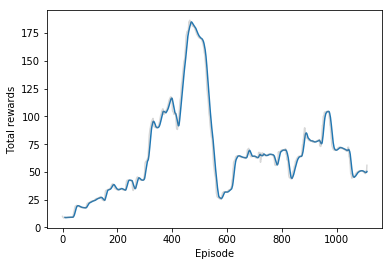

In [100]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

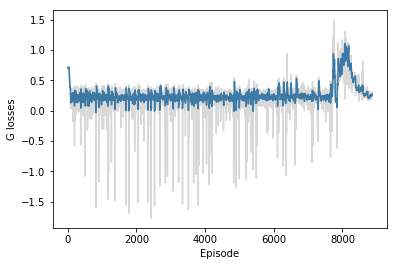

In [26]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

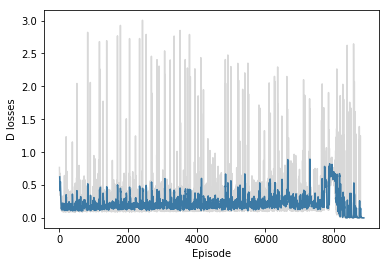

In [27]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.